# Agents with Human-in-the-Loop

We have an email assistant that uses a router to triage emails and then passes the email to the agent for response generation. We've also evaluated it. But do we fully *trust* it to manage our inbox autonomously? For such a sensitive task, human-in-the-loop (HITL) is important! Here we'll show how to add a human-in-the-loop to our email assistant so that we can review specific tool calls. 

![overview-img](img/overview_hitl.png)



We're going to show how to make the graph *pause* at specific points and await human input.

![overview-img](img/hitl_schematic.png)

#### Load Environment Variables

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

## Adding HITL to our email assistant

Let's add HITL to our email assistant. 

We can start with tools, just as we did before. 

But now, we'll add a new tool Question that allows the assistant to ask the user a question.

In [2]:

%load_ext autoreload
%autoreload 2

from typing import Literal
from datetime import datetime
from pydantic import BaseModel

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command

from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl, default_background, default_triage_instructions, default_response_preferences, default_cal_preferences
from email_assistant.tools.default.prompt_templates import HITL_TOOLS_PROMPT
from email_assistant.schemas import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
# This is new! 
class Question(BaseModel):
      """Question to ask user."""
      content: str
    
@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done,
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model(base_url="https://aiportalapi.stu-platform.live/jpe", model="openai:GPT-4o-mini", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model(base_url="https://aiportalapi.stu-platform.live/jpe", model="openai:GPT-4o-mini", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

In [3]:
from rich.markdown import Markdown
Markdown(HITL_TOOLS_PROMPT)

 1 write_email(to, subject, content) - Send emails to specified recipients                                         
 2 schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings  
   where preferred_day is a datetime object                                                                        
 3 check_calendar_availability(day) - Check available time slots for a given day                                   
 4 Question(content) - Ask the user any follow-up questions                                                        
 5 Done - E-mail has been sent

#### Triage node

We define a python function with our triage routing logic, just as we did before.

But, if the classification is `notify`, we want to interrupt the graph to allow the user to review the email! 

So we go to a new node, `triage_interrupt_handler`.

In [4]:
def triage_router(state: State) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 
        # This is new! 
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

#### Triage Interrupt Handler

If the decision is to `notify` the user, we interrupt the graph! 

![overview-img](img/HITL_flow_triage.png)

For this, we add a new node, `triage_interrupt_handler`, that will: 

1. Show the classification to the user if it is `notify`: We'll pass a `dict` to the interrupt that contains our classification. 
2. Allow the user to respond to the decision: We'll design the code to handle what we will get back from Agent Inbox. 

As you can see [here](https://github.com/langchain-ai/agent-inbox?tab=readme-ov-file#what-do-the-fields-mean), we format our interrupt with specific fields so that it can be viewed in Agent Inbox:

* `action_request`: The action and arguments for the interrupt with `action` (the action name) and `args` (the tool call arguments). This is rendered in the Agent Inbox as the main header for the interrupt event.
* `config`: Configures which interaction types are allowed, and specific UI elements for each. 
* `description`: Should be detailed, and may be markdown. This will be rendered in the Agent Inbox as the description


In [5]:
def triage_interrupt_handler(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step."""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt that is shown to the user
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True, 
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Agent Inbox responds with a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`.  
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        # Used by the response agent
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Go to response agent
        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

#### LLM call

The `llm_call` node is the same as before:

In [6]:
def llm_call(state: State):
    """LLM decides whether to call a tool or not."""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl.format(tools_prompt=HITL_TOOLS_PROMPT, 
                                                                                  background=default_background,
                                                                                  response_preferences=default_response_preferences, 
                                                                                  cal_preferences=default_cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

#### Interrupt Handler

The `interrupt_handler` is the core HITL component of our response agent. 

Its job is to examine the tool calls that the LLM wants to make and determine which ones need human review before execution. Here's how it works:

1. **Tool Selection**: The handler maintains a list of "HITL tools" that require human approval:
   - `write_email`: Since sending emails has significant external impact
   - `schedule_meeting`: Since scheduling meetings affects calendars
   - `Question`: Since asking users questions requires direct interaction

2. **Direct Execution**: Tools not in the HITL list (like `check_calendar_availability`) are executed immediately without interruption. This allows low-risk operations to proceed automatically.

3. **Context Preparation**: For tools requiring review, the handler:
   - Retrieves the original email for context
   - Formats the tool call details for clear display
   - Configures which interaction types are allowed for each tool type

4. **Interrupt Creation**: The handler creates a structured interrupt request with:
   - The action name and arguments
   - Configuration for allowed interaction types
   - A description that includes both the original email and the proposed action

5. **Response Processing**: After the interrupt, the handler processes the human response:
   - **Accept**: Executes the tool with original arguments
   - **Edit**: Updates the tool call with edited arguments and then executes
   - **Ignore**: Cancels the tool execution
   - **Response**: Records feedback without execution

This handler ensures humans have oversight of all significant actions while allowing routine operations to proceed automatically. 

The ability to edit tool arguments (like email content or meeting details) gives users precise control over the assistant's actions.

We can visualize the overall flow: 

![overview-img](img/HITL_flow.png)

In [7]:
def interrupt_handler(state: State) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]
            
            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls.
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")
            
        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            elif tool_call["name"] == "Question": 
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")
            
    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

Now, let's compile the graph. 

C:\Users\Admin\AppData\Local\Temp\ipykernel_12060\1607184874.py:38: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  StateGraph(State, input=StateInput)


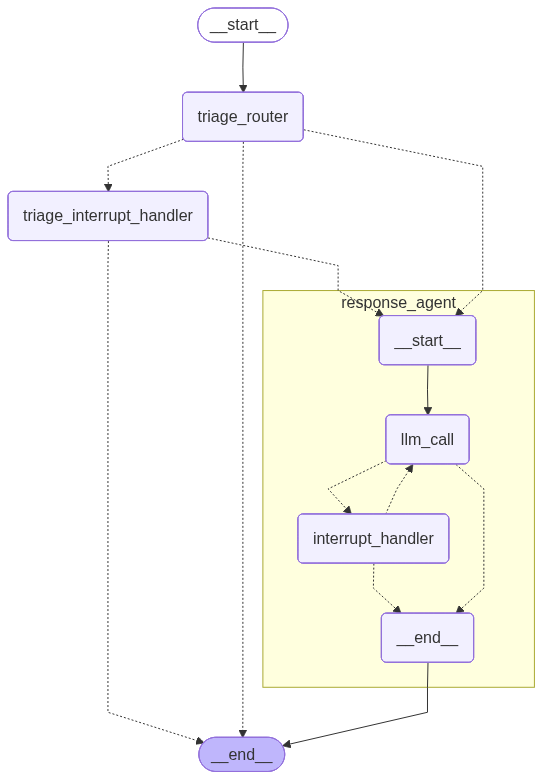

In [8]:
from email_assistant.utils import show_graph

# Conditional edge function
def should_continue(state: State) -> Literal["interrupt_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant, xray=True)

#### Review of HITL Patterns

**Triage Interruption** When an email is classified as "notify", the system interrupts to show the email to the human user
- *User Decision*: User can choose to ignore the notification or provide feedback to respond to the email
- *Flow Control*: If ignored, workflow ends; if user provides feedback, it flows to the Response Agent

**Write Email**: System shows proposed email draft for human review
- *User Decision and Flow Control*: ignore (end workflow), respond with feedback, accept draft as-is, or edit draft

**Schedule Meeting**: System shows proposed meeting details for human review
- *User Decision and Flow Control*: ignore (end workflow), respond with feedback, accept meeting details as-is, or edit details

**Question**: System asks user a question to clarify information
- *User Decision and Flow Control*: ignore (end workflow) or respond with an answer

### Interrupts Allow Us to Review and Accept Tool Calls

In [9]:
import uuid
from langgraph.checkpoint.memory import InMemorySaver

# Email to respond to
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with checkpointer
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until a tool call that we choose to interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...


F:\01_Projects\LangChain\Agents\agents-from-scratch\.venv\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-11-19T14:00:00', 'start_time': 840}}


What happened? We hit the [interrupt](https://langchain-ai.github.io/langgraph/concepts/interrupts/), which paused execution at the tool call. You can see the `action` (tool call name) and `args` (tool call arguments) that we interrupted displayed to the user.

Now, how do we handle the interrupt? This is where the `Command` interface comes in. [The `Command` object has several powerful capabilities](https://langchain-ai.github.io/langgraph/how-tos/command/). We used it to direct the flow of the graph in prior notebooks: 
- `goto`: Specifies which node to route to next
- `update`: Modifies the state before continuing execution

Here, we'll use it to resume the graph from the interrupted state:
- `resume`: Provides the value to return from the interrupt call

We can return whatever value our graph is designed to handle. In our case, the graph is designed to handle a list of dicts with a single key `type` that can be `accept`, `edit`, `ignore`, or `response`. So, we can simply pass `{"type": "accept"}` to the `resume` argument in order to tell the graph that we accept the tool call.

In [10]:
from langgraph.types import Command

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-11-19T14:00:00', 'start_time': 840}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThank you for reaching out regarding tax planning strategies. I would be happy to discuss your suggestions. \n\nI have scheduled a call for Wednesday, November 19, 2025, at 2:00 PM for 45 minutes. \n\nLooking forward to our conversation.\n\nBest regards,\nLance Martin'}}


In [11]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThank you for reaching out regarding tax planning strategies. I would be happy to discuss your suggestions. \n\nI have scheduled a call for Wednesday, November 19, 2025, at 2:00 PM for 45 minutes. \n\nLooking forward to our conversation.\n\nBest regards,\nLance Martin'}} tool call...


In [12]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_q2zwkY7IZUNIX4qE6L3ZDTPR)
 Call ID: call_q2zwkY7IZUNIX4qE6L3ZDTPR
  Args:
    day: 2025-11-21
================================= Tool Message =================================

Available times on 2025-11-21: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==============================



### Interrupts Allow Us to Edit Tool Calls

This test demonstrates how human modification works in the HITL flow:
1. We start with the same tax planning email as before
2. The agent proposes a meeting with the same parameters
3. This time, the user EDITS the meeting proposal to change:
   - Duration from 45 to 30 minutes
   - Meeting subject is made more concise
4. The agent adapts to these changes when drafting the email
5. The user further EDITS the email to be shorter and less formal
6. The workflow completes with both modifications incorporated

This scenario showcases one of the most powerful aspects of HITL: 

* Users can make precise modifications to agent actions before they are executed, ensuring the final outcome matches their preferences without having to handle all the details themselves.

In [13]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-11-19T00:00:00', 'start_time': 120}}


Edit the `schedule_meeting` tool call

When the agent proposes the initial meeting schedule, we now simulate the user making modifications through the edit functionality. This demonstrates how the `edit` response type works:

1. The user receives the same meeting proposal as in the previous test
2. Instead of accepting, they modify the parameters:
   - Reducing duration from 45 to 30 minutes
   - Keeping the same day and time
3. The `edit` response includes the complete set of modified arguments
4. The interrupt handler replaces the original tool arguments with these edited ones
5. The tool is executed with the user's modifications

This shows how edit capability gives users precise control over agent actions while still letting the agent handle the execution details.

In [14]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "2025-05-06",
    "start_time": 14 
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Subject: Re: Tax season let's schedule call\n\nHi,\n\nThank you for reaching out regarding tax planning strategies. I would be happy to discuss your suggestions. \n\nI have scheduled a call for Tuesday, November 21, 2025, at 2:00 PM for 30 minutes. Please let me know if this time works for you.\n\nLooking forward to our conversation.\n\nBest regards,\nLance Martin"}}


Edit the `write_email` tool call

After accepting the modified meeting schedule, the agent drafts an email reflecting the 30-minute duration. Now we demonstrate how editing works with email content:

1. The agent has adapted its email to mention the shorter 30-minute duration
2. We simulate the user wanting an even more significant change to the email:
   - Completely rewriting the content to be shorter and less formal
   - Changing the meeting day mentioned in the email (showing how users can correct agent mistakes)
   - Requesting confirmation rather than stating the meeting as definite
3. The `edit` response contains the complete new email content
4. The tool arguments are updated with this edited content
5. The email is sent with the user's preferred wording

This example shows the power of HITL for complex communication tasks - the agent handles the structure and initial content, while humans can refine tone, style, and substance.

In [15]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_GOgDf0zjJCtkfBlK61x9zW0w)
 Call ID: call_GOgDf0zjJCtkfBlK61x9zW0w
  Args:
    done: True


Look at the full message history, and see trace, to view the edited tool calls:

https://smith.langchain.com/public/21769510-d57a-41e4-b5c7-0ddb23c237d8/r

In [16]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_57ML5Q6b72V7ySpFDV65FAV6)
 Call ID: call_57ML5Q6b72V7ySpFDV65FAV6
  Args:
    day: 2025-11-21
================================= Tool Message =================================

Available times on 2025-11-21: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==============================

### Interrupts Allow Us to Provide Feedback on Tool Calls

This test set demonstrates the "response" capability - providing feedback without editing or accepting:

1. First, we test feedback for meeting scheduling:
   - The user provides specific preferences (30 minutes instead of 45, and afternoon meetings)
   - The agent incorporates this feedback into a revised proposal
   - The user then accepts the revised meeting schedule

2. Second, we test feedback for email drafting:
   - The user requests a shorter, less formal email with a specific closing statement
   - The agent completely rewrites the email according to this guidance
   - The user accepts the new draft

3. Lastly, we test feedback for questions:
   - For the brunch invitation, the user answers the question with additional context
   - The agent uses this information to draft an appropriate email response
   - The workflow proceeds with the user's input integrated

The "response" capability bridges the gap between acceptance and editing - users can guide the agent without having to write the full content themselves. This is especially powerful for:
- Adjusting tone and style
- Adding context the agent missed
- Redirecting the agent's approach
- Answering questions in a way that shapes the next steps

In [17]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-11-19T00:00:00Z', 'start_time': 120}}


Provide feedback for the `schedule_meeting` tool call

Now we explore the feedback capability for meeting scheduling:

1. The agent proposes the standard 45-minute meeting on Tuesday at 2:00 PM
2. Instead of accepting or editing, we provide feedback in natural language
3. Our feedback specifies two preferences:
   - Shorter meeting (30 minutes instead of 45)
   - Preference for afternoon meetings (after 2pm)
4. The agent receives this feedback through the `response` type
5. The interrupt handler adds this feedback as a message to the state
6. The agent processes this feedback and generates a new tool call incorporating these preferences

Unlike direct editing, which requires specifying the entire set of parameters, feedback allows users to express their preferences conversationally. The agent must then interpret this feedback and apply it appropriately to create a revised proposal.

In [18]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-11-19T00:00:00Z', 'start_time': 120}}


Accept the `schedule_meeting` tool call after providing feedback

In [19]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['lance@company.com', 'pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-11-19T00:00:00Z', 'start_time': 120}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Subject: Re: Tax season let's schedule call\n\nHi,\n\nThank you for reaching out regarding tax planning strategies. I would be happy to discuss this with you. \n\nI have scheduled a call for Wednesday, November 19, 2025, at 2:00 PM for 30 minutes. Please let me know if this works for you.\n\nLooking forward to our conversation.\n\nBest regards,\nLance Martin"}}


Now provide feedback for the `write_email` tool call

After accepting the revised meeting schedule, the agent drafts an email. We now test feedback for email content:

1. The agent's email is relatively formal and detailed
2. We provide stylistic feedback requesting:
   - A shorter, more concise email
   - A less formal tone
   - A specific closing statement about looking forward to the meeting
3. The agent processes this feedback to completely rewrite the email
4. The new draft is much shorter, more casual, and includes the requested closing

This demonstrates the power of natural language feedback for content creation:
- Users don't need to rewrite the entire email themselves
- They can provide high-level guidance on style, tone, and content
- The agent handles the actual writing based on this guidance
- The result better matches user preferences while preserving the essential information

The message history shows both the original and revised emails, clearly showing how the feedback was incorporated.

In [20]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nThanks for reaching out! I've scheduled our call for Wednesday, November 19, 2025, at 2:00 PM for 30 minutes. \n\nLooking forward to it!\n\nBest,\nLance"}}


Accept the `write_email` tool call after providing feedback

In [21]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nThanks for reaching out! I've scheduled our call for Wednesday, November 19, 2025, at 2:00 PM for 30 minutes. \n\nLooking forward to it!\n\nBest,\nLance"}} tool call...


Look at the full message history, and see the trace:

https://smith.langchain.com/public/57006770-6bb3-4e40-b990-143c373ebe60/r

We can see that user feedback in incorporated into the tool calls.  

In [22]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_EayOrwQorujhiukyMkIpgoPA)
 Call ID: call_EayOrwQorujhiukyMkIpgoPA
  Args:
    day: 2025-11-21
================================= Tool Message =================================

Available times on 2025-11-21: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==============================

### Interrupts Enable New Tools

Now let's try an email that calls the `Question` tool to provide feedback

Finally, we test how feedback works with the `Question` tool:

1. For the brunch invitation email, the agent asks about preferred day and time
2. Instead of ignoring, we provide a substantive response with additional context:
   - Confirming we want to invite the people mentioned
   - Noting we need to check which weekend works best
   - Adding information about needing a reservation
3. The agent uses this information to:
   - Draft a comprehensive email response incorporating all our feedback
   - Notice we didn't provide a specific day/time, so it suggests checking the calendar
   - Include the detail about making a reservation
4. The complete email reflects both the original request and our additional guidance

This demonstrates how question responses can shape the entire workflow:
- Questions let the agent gather missing information
- User responses can include both direct answers and additional context
- The agent integrates all this information into its next actions
- The final outcome reflects the collaborative intelligence of both human and AI

In [23]:
# Respond
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Dinner?",
    "email_thread": "Hey, do you want italian or indian tonight?"}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'Which cuisine do you prefer for dinner tonight, Italian or Indian?'}}


Provide feedback for the `Question` tool call

In [24]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Let's do indian."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Dinner?', 'content': "Hi,\n\nLet's go with Indian for dinner tonight. Looking forward to it!\n\nBest,\nLance"}}


Accept the `write_email` tool call

In [25]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_CWtDVIqLUAiRphOFQzuN1OLt)
 Call ID: call_CWtDVIqLUAiRphOFQzuN1OLt
  Args:
    done: True


Look at the full message history, and see the trace:

https://smith.langchain.com/public/f4c727c3-b1d9-47a5-b3d0-3451619db8a2/r

We can see that user feedback in incorporated into the email response.

In [26]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Dinner?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, do you want italian or indian tonight?

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_XAZwF9mR4gXvgE1CDLPcP0bS)
 Call ID: call_XAZwF9mR4gXvgE1CDLPcP0bS
  Args:
    content: Which cuisine do you prefer for dinner tonight, Italian or Indian?
================================= Tool Message =================================

User answered the question, which can we can use for any follow up actions. Feedback: Let's do indian.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_6FBJYsCbkCrKCHhxNrf9XvYK)
 Call ID: call_6FBJYsCbkCrKCHhxNrf9XvYK
  Args:
    to: partner@home.com
    subject: Re: Dinner?
    content: Hi,

Let's go with Indian for dinner tonight.

### Deployment

Let's create a local deployment of our email assistant with HITL from `src/email_assistant/email_assistant_hitl.py`. 
 
As before, run `langgraph dev`, select `email_assistant_hitl` in Studio, and submit the e-mail:

In [27]:
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

{'author': 'Alice Smith <alice.smith@company.com>',
 'to': 'John Doe <john.doe@company.com>',
 'subject': 'Quick question about API documentation',
 'email_thread': "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"}

Our server it stateless. Threads with a local deployment are simply saved to the local filesystem (`.langgraph_api` in the project folder).

With a [hosted](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options) deployment, threads stored in Postgres.

Interrupted threads are threads with status 'interrupted', and we can see the interrupt in Studio: 

![studio-img](img/studio-interrupt.png)

We'll use a custom interface to view these interrupted threads, [Agent Inbox](https://dev.agentinbox.ai/). 

This interface is a nice way to edit, approve, ignore, or provide feedback on specific actions taken by LangGraph agents. 

If you go to [dev.agentinbox.ai](https://dev.agentinbox.ai/), you can easily connect to the graph:
   * Graph name: the name from the `langgraph.json` file (`email_assistant_hitl`)
   * Graph URL: `http://127.0.0.1:2024/`

All interrupted threads run will then be visible: 

![agent-inbox-img](img/agent-inbox.png)

Agent Inbox simply uses a `Command` with `resume`, as [shown with the SDK](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#interacting-with-the-agent) above, the resume the graph.